In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2024-04-29 23:15:51.653601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
data =  pd.read_csv('Stock Market/prices-split-adjusted.csv', header=0)


In [21]:
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [22]:
print(data.columns)
print(data.shape)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
(289828, 7)


In [23]:
data.iloc[:, 2:-1].describe()

,open,close,low,high
count,289828.000000,289828.000000,289828.000000,289827.000000
mean,45.928953,45.943631,45.390623,46.451285
std,42.559741,42.575850,42.070270,43.039626
min,2.980000,3.020000,2.820000,3.200000
25%,24.119746,24.129063,23.809999,24.430000
50%,36.680000,36.689999,36.270000,37.098000
75%,55.000000,55.020000,54.393143,55.590000
max,768.500000,764.750000,751.000000,774.960022


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289828 entries, 0 to 289827
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    289828 non-null  object 
 1   symbol  289828 non-null  object 
 2   open    289828 non-null  float64
 3   close   289828 non-null  float64
 4   low     289828 non-null  float64
 5   high    289827 non-null  float64
 6   volume  289827 non-null  float64
dtypes: float64(5), object(2)
memory usage: 15.5+ MB


In [25]:
print(len(data['symbol'].unique()))
symbols = data['symbol'].unique()

471


In [26]:
data['symbol'].describe()


count     289828
unique       471
top          JCI
freq         617
Name: symbol, dtype: object

In [15]:
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

FLS


In [27]:
data_prices = data[data['symbol'] == choosen_symbol].reset_index(drop = True)
data_prices.iloc[:10, :]

,date,symbol,open,close,low,high,volume
0,2010-01-04,FLS,32.130001,32.336666,31.719999,32.443333,2161800.0
1,2010-01-05,FLS,32.366665,32.696667,32.200001,32.990002,2363100.0
2,2010-01-06,FLS,32.669998,33.599998,32.669998,33.636665,3473700.0
3,2010-01-07,FLS,33.583332,34.523335,33.483334,34.646667,3660600.0
4,2010-01-08,FLS,34.259998,35.959999,34.259998,35.990002,6993300.0
5,2010-01-11,FLS,36.003334,36.136665,35.560001,36.263332,3102000.0
6,2010-01-12,FLS,35.746666,35.106667,34.889999,35.750000,2662500.0
7,2010-01-13,FLS,35.156666,35.086666,34.310001,35.373333,1877100.0
8,2010-01-14,FLS,35.049999,35.336666,34.720001,35.553333,1461900.0
9,2010-01-15,FLS,35.296665,34.906666,34.776669,35.410000,1411500.0


In [28]:
data_prices = data_prices.drop(['date', 'symbol'], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


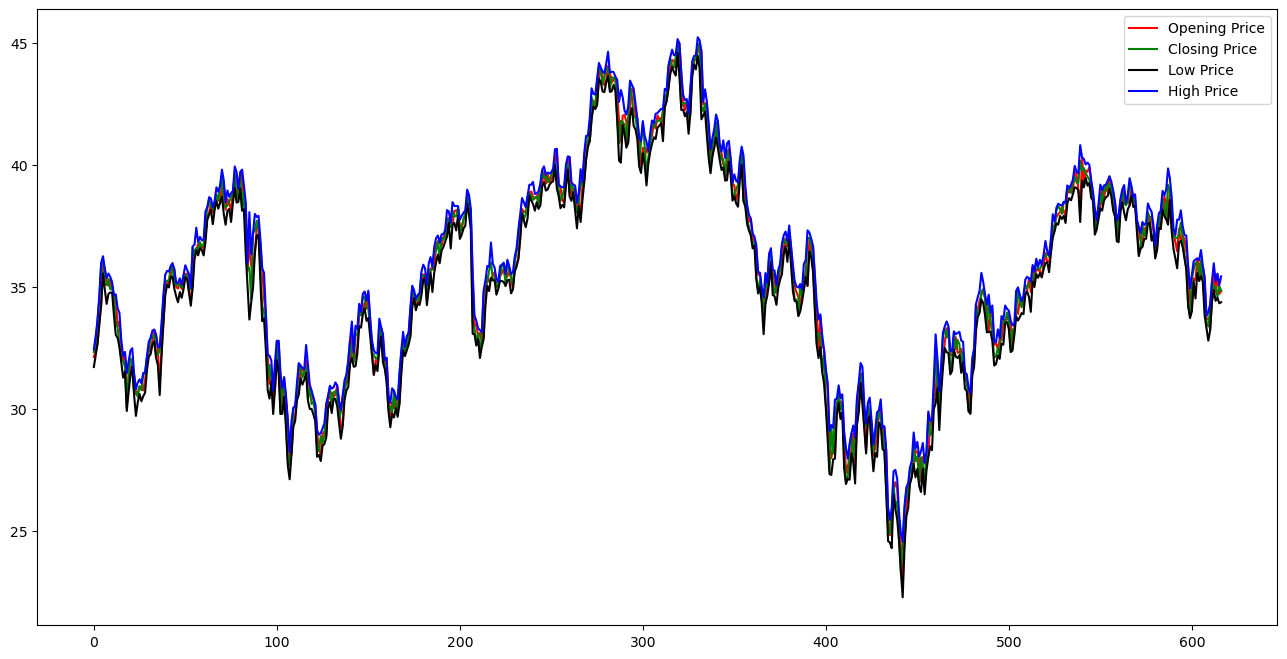

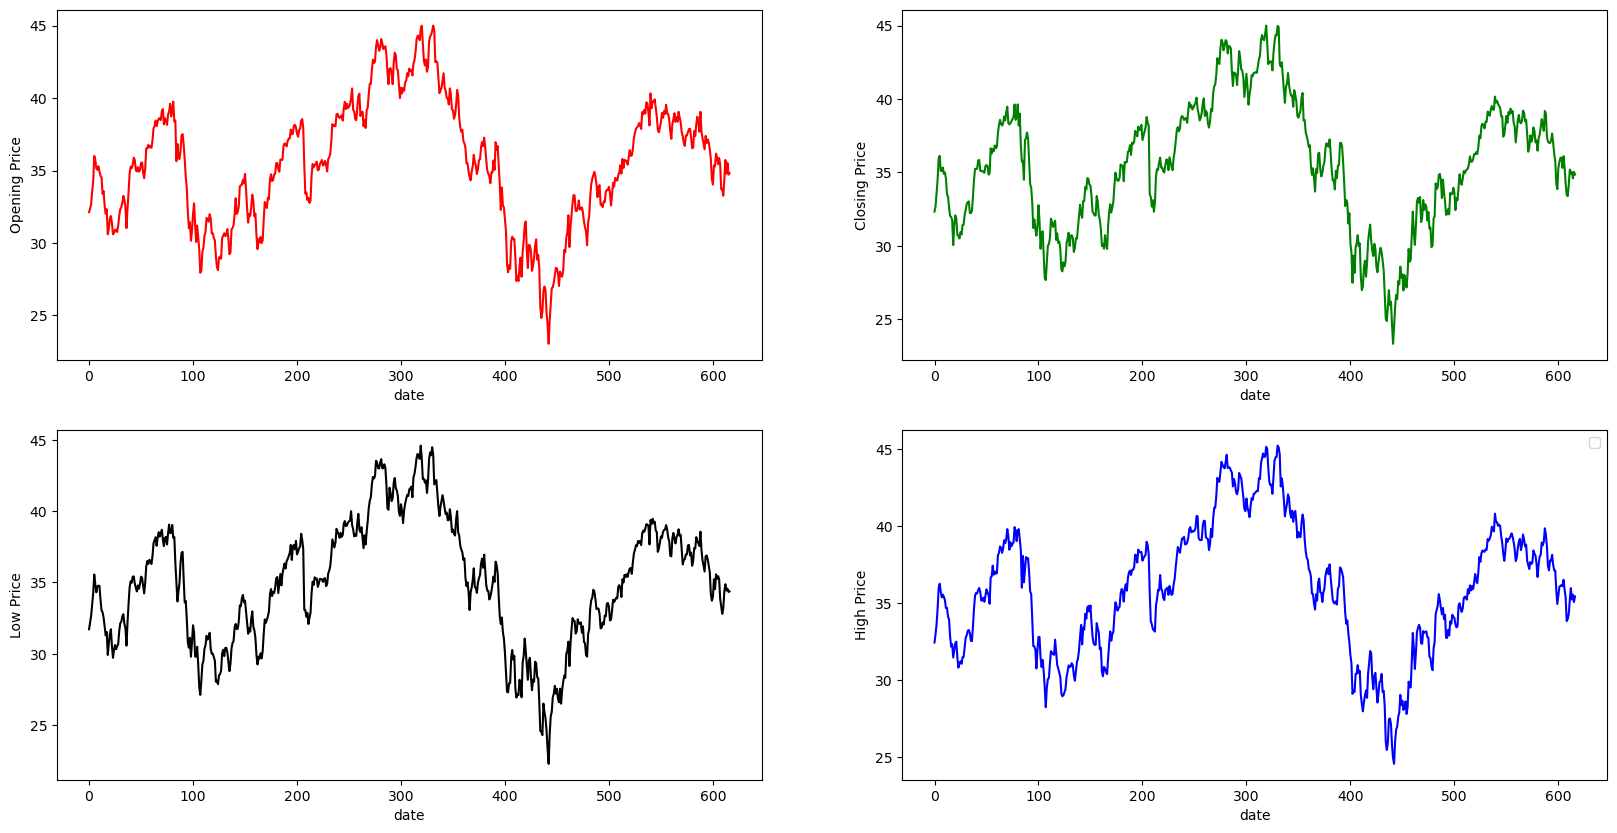

In [29]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('date')
plt.ylabel('Closing Price')
ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('date')
plt.ylabel('High Price')

plt.legend(loc='best')

In [30]:
data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

In [31]:
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [32]:
data_prices_scaled.shape

(617, 2)

Creating LSTM input data

In [33]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point] 
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [34]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8, validation_split_percentage = 0)

In [35]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(474, 25, 2)
(118, 25, 2)
(474, 1)
(118, 1)


In [36]:
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

2024-04-29 23:37:25.181943: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1216      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3345 (13.07 KB)
Trainable params: 3345 (13.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
6/6 [==============================] - 5s 178ms/step - loss: 0.4400 - root_mean_squared_error: 0.6633 - val_loss: 0.1118 - val_root_mean_squared_error: 0.3344
Epoch 2/40
6/6 [==============================] - 0s 40ms/step - loss: 0.2471 - root_mean_squared_error: 0.4970 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2098
Epoch 3/40
6/6 [==============================] - 0s 39ms/step - loss: 0.1105 - root_mean_squared_error: 0.3324 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 4/40
6/6 [==============================] - 0s 40ms/step - loss: 0.0331 - root_mean_squared_error: 0.1818 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 5/40
6/6 [==============================] - 0s 45ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2208
Epoch 6/40
6/6 [==============================] - 0s 43ms/step - loss: 0.0354 - root_mean_squared_error: 0.1882 - val_loss: 0.0341 - val_root_mean_squared

In [38]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

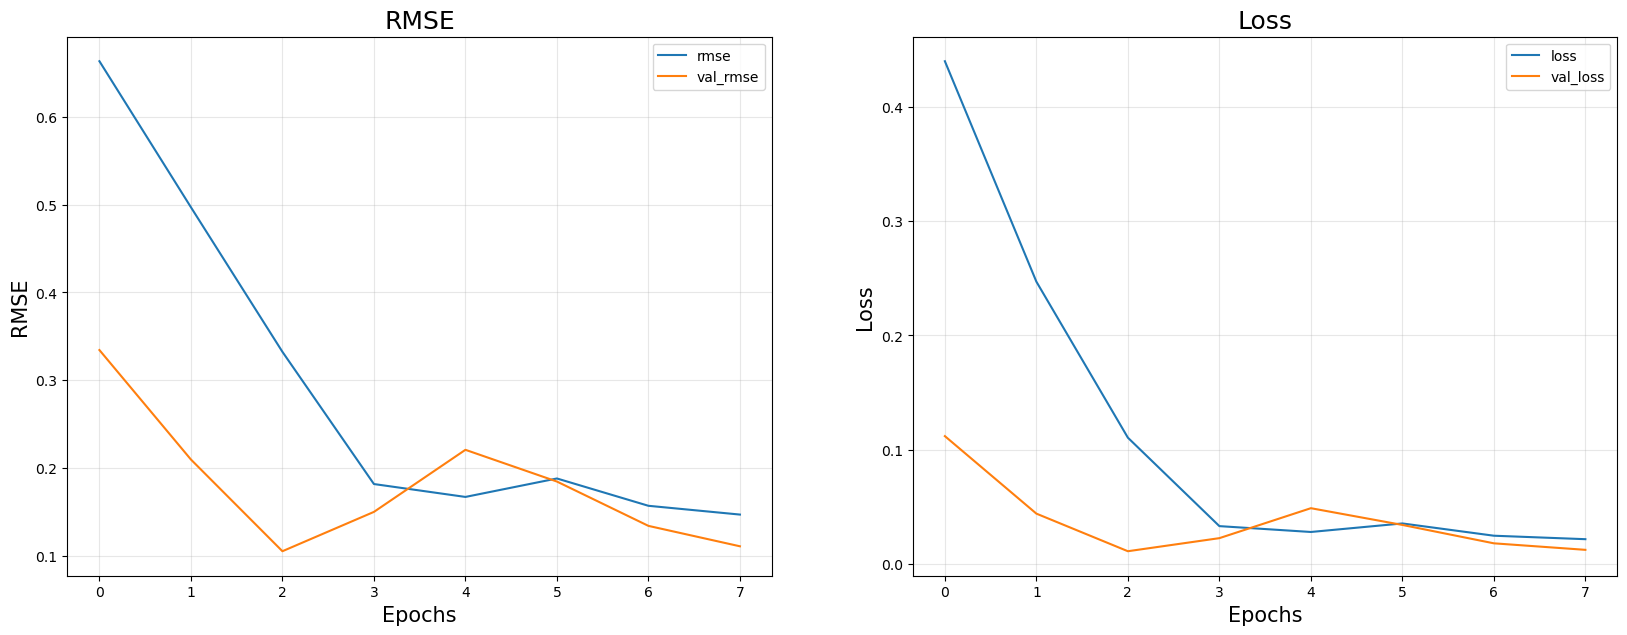

In [39]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [40]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

4/4 [==============================] - 0s 8ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590
test loss, test acc: [0.0035 0.059 ]


Hyperparameter Tunning

In [49]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        re = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        
        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [50]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

In [51]:
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.02356, saving model to best_model.h5


/glob/development-tools/versions/oneapi/2023.2.0.1/inteloneapi/tensorflow/latest/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.02356 to 0.01041, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.01041

Epoch 4: val_loss did not improve from 0.01041

Epoch 5: val_loss did not improve from 0.01041

Epoch 6: val_loss improved from 0.01041 to 0.00834, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00834

Epoch 8: val_loss did not improve from 0.00834

Epoch 9: val_loss improved from 0.00834 to 0.00708, saving model to best_model.h5

Epoch 10: val_loss did not improve from 0.00708

Epoch 11: val_loss did not improve from 0.00708

Epoch 12: val_loss did not improve from 0.00708

Epoch 13: val_loss did not improve from 0.00708

Epoch 14: val_loss did not improve from 0.00708
Epoch 14: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.006927529815584421, 0.08323178440332413] and test accuracy: [0.0021191982086747885, 0.04603474959731102]
--------------------------------------------------------------

In [52]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
3,False,False,False,32,8,0.2,"[0.005289324093610048, 0.0727277398109436]","[0.001496572745963931, 0.03868556395173073]"
5,False,False,False,32,32,0.2,"[0.006477114744484425, 0.08048052340745926]","[0.0020767853129655123, 0.04557175934314728]"
0,False,False,False,16,8,0.2,"[0.006927529815584421, 0.08323178440332413]","[0.0021191982086747885, 0.04603474959731102]"
2,False,False,False,16,32,0.2,"[0.008270438760519028, 0.09094195067882538]","[0.0025041119661182165, 0.05004110187292099]"
1,False,False,False,16,16,0.2,"[0.008014045655727386, 0.08952119946479797]","[0.0027226831298321486, 0.05217933654785156]"
4,False,False,False,32,16,0.2,"[0.005974968895316124, 0.07729792594909668]","[0.0028740940615534782, 0.053610578179359436]"


In [53]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.059

Results After Tunning:
 Test Set RMSE: 0.0387

34.0% Improvement


In [54]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [55]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.01699, saving model to best_model.h5


/glob/development-tools/versions/oneapi/2023.2.0.1/inteloneapi/tensorflow/latest/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.01699 to 0.00777, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00777 to 0.00747, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00747

Epoch 5: val_loss did not improve from 0.00747

Epoch 6: val_loss did not improve from 0.00747

Epoch 7: val_loss did not improve from 0.00747

Epoch 8: val_loss did not improve from 0.00747
Epoch 8: early stopping


In [56]:
regressor.evaluate(X_test, y_test)

4/4 [==============================] - 0s 11ms/step - loss: 0.0043


0.00430317921563983

4/4 [==============================] - 1s 8ms/step


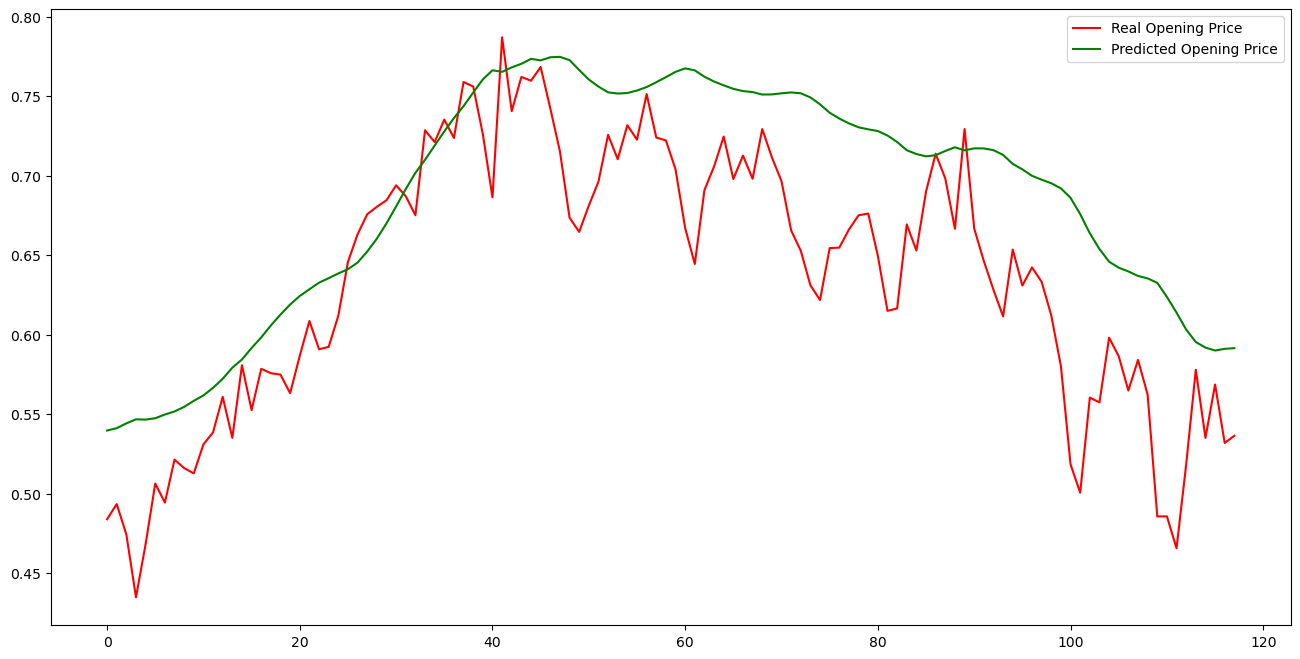

In [57]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')